In [55]:
%load_ext autoreload
%autoreload 2

from calc_del_lambda import import_lab_frame_spectra
lab = import_lab_frame_spectra('/home/agoga/Documents/nreshk/data/LabSpectra/', resolution=0)#,res*10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import scipy as sc
from scipy import interpolate

import astropy.io.fits
import numpy as np
import os

from calc_shk import calc_targOlapf
from calc_shk import calc_shk


from calc_del_lambda import tmp_find_del_lam
from calc_del_lambda import lamda_zoom
from calc_del_lambda import pdf_from_data
from helpers import mkdir_p
from helpers import bad_spec_detection

from mk_flatolap import mk_flatolap
from matplotlib import pyplot as plt

from astropy.time import Time
from matplotlib.backends.backend_pdf import PdfPages


def print_header(hdu):
    for i in hdu[0].header:
        print(i + ': ' + str(hdu[0].header[i]))
def mjd_from_hdu(hdu):
    return hdu[0].header['MJD-OBS']

#https://stackoverflow.com/questions/47725773/finding-an-integer-key-of-a-python-dict-that-is-closest-to-a-given-integer
def find_nearest_mjd(dd,mjd):
    low = max([d for d in dd if d<= mjd])
    high = min([d for d in dd if d>= mjd])
    nearkey = low if mjd - low <= high - mjd else high
    return nearkey
def closestKey(dic, key):
    diff = {k:abs(k - key) for k in dic}
    return min(diff, key=diff.get)


dataPath ='/home/agoga/Documents/nreshk/data/smarts/'
padWidth= 1000
hduList = []
data = [[],[]]
for root, dirs, files in os.walk(dataPath):
    dirs[:] = [d for d in dirs if d not in exclude]
    
    for file in files:
        if file.endswith(".fits"):
            hdu = astropy.io.fits.open(os.path.join(root, file))
            
            #print_header(hdu)
            hduList.append(hdu)
            spec = hdu[0].data[0][0]
            
            lamStep = hdu[0].header['CD1_1']#lamda grid step value
            lamStart = hdu[0].header['CRVAL1'] #labda grid start value
            
            lamGrid = lamStart + np.arange(len(spec))*lamStep
            
            
            #RICKY HACK
            adjLamGrid = lamStart + np.arange(len(spec)*10)*lamStep/10
            #print(lamGrid)
            #print(adjLamGrid)
            interpfunc = interpolate.interp1d(lamGrid, spec, kind='linear',fill_value='extrapolate')
            
            adjSpec=interpfunc(adjLamGrid)
            #E HACK
            
            #lamda grid padding 
            #backPad = lamGrid[-1] + np.arange(padWidth)*lamStep
            #frontPad = np.flip(lamGrid[0] - np.arange(padWidth)*lamStep)
            
           # lamGrid = np.append(np.append(frontPad,lamGrid),backPad)
            
            lamGrid = lamGrid/10
            labGrid=lab[0]/10
            
            #need to pad the edges with 0's
            #spec = np.pad(spec,pad_width=padWidth,mode='constant',constant_values=0)
            
            #plt.figure(figsize=(20,6))
            #plt.plot(lamGrid,spec,'g-')
            #plt.show()
            #plt.close()
            
            
            
            
            
            
            #gausLab = sc.ndimage.filters.gaussian_filter(labSpc,.1/dLam)
            out = tmp_find_del_lam(labGrid,lab[1],lamGrid, spec,1)
           # print(out)
            dLam = out[0]
            labSpec = out[2]

            
            #RICKY HACK
            dLam = dLam*10
            #E
            
            
            #plt.figure(figsize=(20,6))
           # plt.plot(lamGrid,out[2]*1000,'b-')
            #plt.plot(lamGrid,spec,'g-')
            ##plt.show()
            #plt.close()
            
            print('lamd adj: ' + str(dLam*10))
            shkRet = calc_shk(lamGrid-dLam, spec, 0, teff=6200)
            #shkRet = calc_shk(adjLamGrid/10-dLam, adjSpec, 0, teff=6200)
            shk = shkRet[0]
            windows = shkRet[1]
            
            
            
            
            #HELL TIME CONVERSION
            import time
            from astropy.time import Time
            fileDate = hdu[0].header['WAVEFILE'][4:]
            date = time.strptime(fileDate, "%a %b %d %H:%M:%S %Y")
            iso = time.strftime('%Y-%m-%dT%H:%M:%SZ', date)
            
            t= Time(iso, format='isot')
            t.format = 'decimalyear'
            ##E
            label = str(t.value)
            print("shk: " + str(shk) + " for obs: "+label)
            mkdir_p("output/"+"SMARTS/")
            #pdf_from_data(lamGrid, labSpec,adjLamGrid-dLam, adjSpec, adjSpec,windows, "output/"+"SMARTS/",label,.3)
            
            data[0].append(t.value)
            data[1].append(shk)

lamd adj: 5.64154714062397
shk: 0.8976645064466668 for obs: 2008.1227304062943
lamd adj: 0.0
shk: 0.3566919615414125 for obs: 2008.1227304062943
lamd adj: 0.0
shk: 0.3496676629008293 for obs: 2008.2051531193079
lamd adj: 0.0
shk: 0.35542056176631787 for obs: 2008.2051531193079
lamd adj: 0.0
shk: 0.3637481179082188 for obs: 2008.5191245446265
lamd adj: 0.0
shk: 0.3647622464830902 for obs: 2008.5191245446265
lamd adj: 0.0
shk: 0.3514688313038436 for obs: 2008.5618878390003
lamd adj: 0.0
shk: 0.3596173139900412 for obs: 2008.5618878390003
lamd adj: 0.0
shk: 0.33450046704235803 for obs: 2008.568637295082
lamd adj: 0.0
shk: 0.33866212598475687 for obs: 2008.568637295082


KeyboardInterrupt: 

115
145


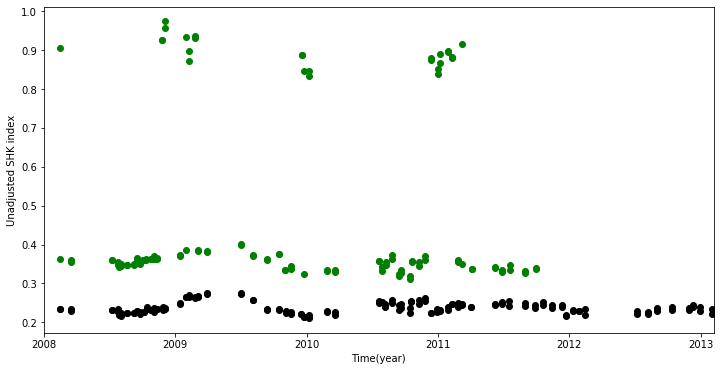

ValueError: operands could not be broadcast together with shapes (115,) (145,) 

In [61]:
shkArray = np.asarray(data)

realFile = open(dataPath+"HD17051.txt", "r")
realData = realFile.readlines()

perfData = [[],[]]
for x in realData:pri
    cDate = x.split('     ')[0]
    cShk = x.split('     ')[1]
    #print(cDate + ' : ' + cShk)
    perfData[0].append(float(cDate))
    perfData[1].append(float(cShk))
realFile.close()

#siteArray = np.asarray(sites)
plt.figure(figsize=(12,6))    
#t= Time(shkArray[0], format='mjd')
#t.format = 'decimalyear'
plt.xlim([2008,2013.1])
#plt.ylim([.18,.45])
#print(perfData[0])
plt.plot(shkArray[0],shkArray[1], 'go')
plt.plot(perfData[0],perfData[1], 'ko')
print(len(shkArray[0]))
print(len(perfData[0]))
#plt.title('HD '+setName+' magnetic activity cycle')
plt.xlabel('Time(year)')
plt.ylabel('Unadjusted SHK index')
plt.savefig('output/SmartsSHKs.pdf')
#plt.savefig('output/'+setName+'shk_time_series.pdf')
plt.show()
plt.close()


diffArr = (shkArray[1]-perfData[1])
tArr  = shkArray[0][abs(diffArr)< .7] 
diffArr = diffArr[abs(diffArr)< .7]
mean = np.mean(diffArr)


plt.figure(figsize=(12,6))  
plt.plot(tArr,diffArr/mean-1,'ko')
plt.xlabel('Time(year)')
plt.ylabel('Difference between two shks')
plt.savefig('output/SmartsDifferences.pdf')
plt.show()
plt.close()

print('mean: '+str(mean))